In [2]:
import numpy as np
import os

os.environ['CUDA_VISIBLE_DEVICES'] = '1'
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'

In [3]:
actions = [
    'come',
    'away',
    'spin'
]

data = np.concatenate([
    np.load('dataset/seq_come_1708447662.npy'),
    np.load('dataset/seq_away_1708447662.npy'),
    np.load('dataset/seq_spin_1708447662.npy')
], axis=0)

data.shape

(2533, 30, 100)

In [4]:
x_data = data[:, :, :-1]
labels = data[:, 0, -1]

print(x_data.shape)
print(labels.shape)

(2533, 30, 99)
(2533,)


In [5]:
from tensorflow import keras
from keras.utils import to_categorical

y_data = to_categorical(labels, num_classes=len(actions))
y_data.shape

(2533, 3)

In [6]:
from sklearn.model_selection import train_test_split

x_data = x_data.astype(np.float32)
y_data = y_data.astype(np.float32)

x_train, x_val, y_train, y_val = train_test_split(x_data, y_data, test_size=0.1, random_state=2021)

print(x_train.shape, y_train.shape)
print(x_val.shape, y_val.shape)

(2279, 30, 99) (2279, 3)
(254, 30, 99) (254, 3)


In [7]:
from keras.models import Sequential
from keras.layers import LSTM, Dense

model = Sequential([
    LSTM(64, activation='relu', input_shape=x_train.shape[1:3]),
    Dense(32, activation='relu'),
    Dense(len(actions), activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])
model.summary()



Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 64)                41984     
                                                                 
 dense (Dense)               (None, 32)                2080      
                                                                 
 dense_1 (Dense)             (None, 3)                 99        
                                                                 
Total params: 44163 (172.51 KB)
Trainable params: 44163 (172.51 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [8]:
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau

history = model.fit(
    x_train,
    y_train,
    validation_data=(x_val, y_val),
    epochs=200,
    callbacks=[
        ModelCheckpoint('models/model.h5', monitor='val_acc', verbose=1, save_best_only=True, mode='auto'),
        ReduceLROnPlateau(monitor='val_acc', factor=0.5, patience=50, verbose=1, mode='auto')
    ]
)

Epoch 1/200


71/72 [============================>.] - ETA: 0s - loss: 32.9295 - acc: 0.5568
Epoch 1: val_acc improved from -inf to 0.76772, saving model to models\model.h5
72/72 [==============================] - 2s 13ms/step - loss: 32.8599 - acc: 0.5568 - val_loss: 3.6998 - val_acc: 0.7677 - lr: 0.0010
Epoch 2/200
21/72 [=======>......................] - ETA: 0s - loss: 3.1942 - acc: 0.7366

c:\Users\mshof\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


70/72 [============================>.] - ETA: 0s - loss: 3.4500 - acc: 0.6915
Epoch 2: val_acc did not improve from 0.76772
72/72 [==============================] - 1s 10ms/step - loss: 3.4507 - acc: 0.6898 - val_loss: 10.0440 - val_acc: 0.5276 - lr: 0.0010
Epoch 3/200
68/72 [===========================>..] - ETA: 0s - loss: 8.9457 - acc: 0.4127
Epoch 3: val_acc did not improve from 0.76772
72/72 [==============================] - 1s 11ms/step - loss: 8.6775 - acc: 0.4147 - val_loss: 3.8912 - val_acc: 0.4488 - lr: 0.0010
Epoch 4/200
67/72 [==========================>...] - ETA: 0s - loss: 4.9006 - acc: 0.5173
Epoch 4: val_acc did not improve from 0.76772
72/72 [==============================] - 1s 10ms/step - loss: 4.7287 - acc: 0.5257 - val_loss: 2.0591 - val_acc: 0.6811 - lr: 0.0010
Epoch 5/200
67/72 [==========================>...] - ETA: 0s - loss: 1.4914 - acc: 0.6903
Epoch 5: val_acc did not improve from 0.76772
72/72 [==============================] - 1s 10ms/step - loss: 1.4600

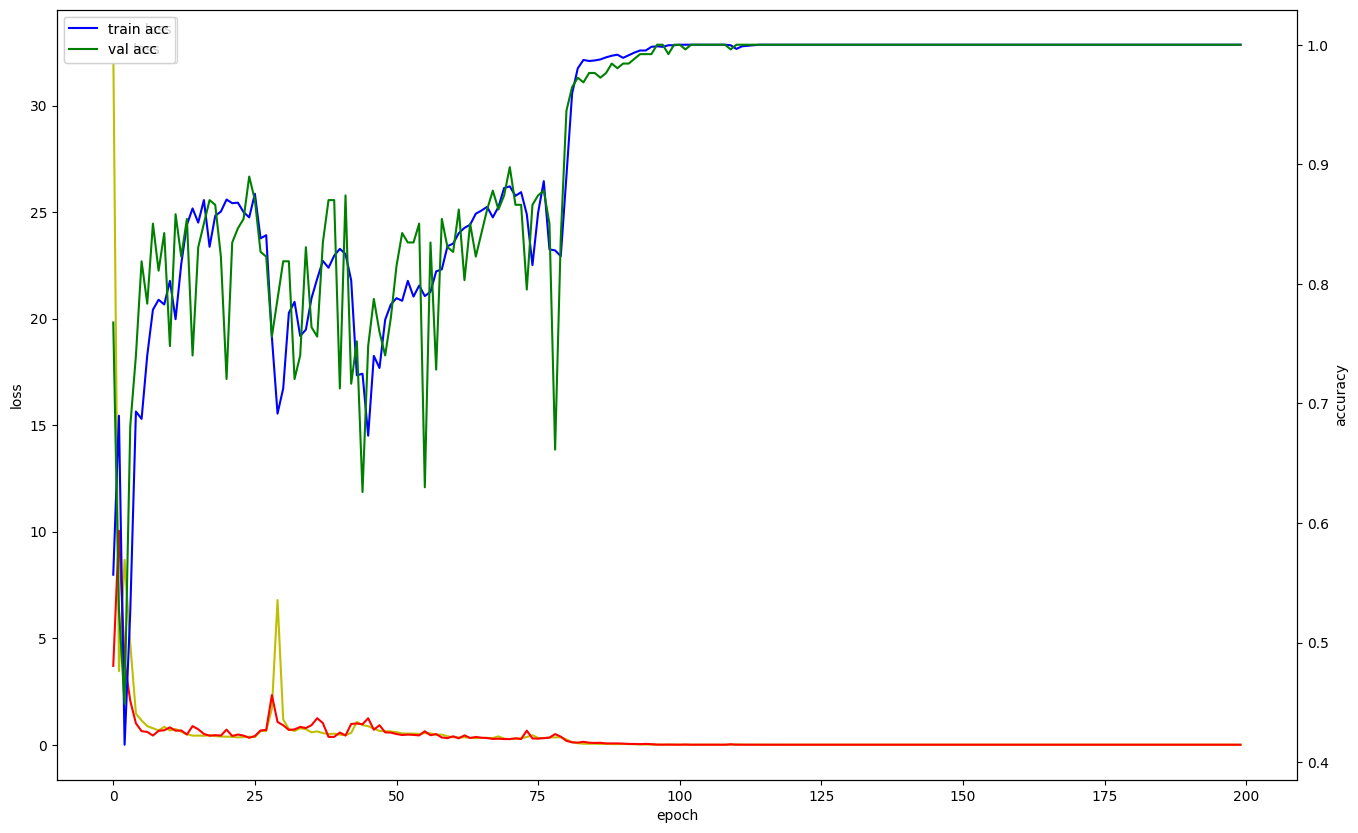

In [9]:
import matplotlib.pyplot as plt

fig, loss_ax = plt.subplots(figsize=(16, 10))
acc_ax = loss_ax.twinx()

loss_ax.plot(history.history['loss'], 'y', label='train loss')
loss_ax.plot(history.history['val_loss'], 'r', label='val loss')
loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
loss_ax.legend(loc='upper left')

acc_ax.plot(history.history['acc'], 'b', label='train acc')
acc_ax.plot(history.history['val_acc'], 'g', label='val acc')
acc_ax.set_ylabel('accuracy')
acc_ax.legend(loc='upper left')

plt.show()

In [10]:
from sklearn.metrics import multilabel_confusion_matrix
from keras.models import load_model

model = load_model('models/model.h5')

y_pred = model.predict(x_val)

multilabel_confusion_matrix(np.argmax(y_val, axis=1), np.argmax(y_pred, axis=1))

8/8 [==============================] - 0s 3ms/step


array([[[174,   0],
        [  0,  80]],

       [[168,   0],
        [  0,  86]],

       [[166,   0],
        [  0,  88]]], dtype=int64)